In [25]:
# Library imports (see /Utilities/setup_env.py for full import list and figure setup)

from pathlib import Path
import sys

repo_root = Path.cwd().parents[1]  # .../Figure_analysis
repo_root = repo_root.parent       # repo root
sys.path.insert(0, str(repo_root))

from Figure_analysis.Utilities.setup_env import *

In [26]:
# Figure-specific matplotlib configuration
mpl.rcParams["lines.linewidth"] = 0.5
mpl.rcParams["axes.linewidth"] = 0.5

mpl.rcParams.update({
    "xtick.major.width": 0.5,
    "ytick.major.width": 0.5,
    "xtick.minor.width": 0.5,
    "ytick.minor.width": 0.5,
})

# set font size
mpl.rcParams.update({'font.size': 7})

def thousands(x, pos):
    'The two args are the value and tick position, helper fn'
    return '%1.2f' % (x * 1e3)

In [27]:
nerd_sqlite = '../../../Core_nerd_analysis/nerd.sqlite'

db_path = Path(nerd_sqlite).expanduser().resolve()
if not db_path.exists():
    raise FileNotFoundError(f"Database not found: {db_path}")

conn = sqlite3.connect(db_path)
conn.row_factory = sqlite3.Row

def read_sql(query: str, params: dict | None = None) -> pd.DataFrame:
    """Run a SQL query against the configured database and return a DataFrame."""
    return pd.read_sql_query(query, conn, params=params or {})

In [28]:
# Load all fit parameters for round3_constrained modrate fits
fit_params_df = read_sql(
    """
    WITH run AS (
        SELECT
            r.id  AS fit_run_id,
            r.rg_id,
            mn.site,
            UPPER(mn.base) AS base
        FROM probe_tc_fit_runs r
        JOIN meta_nucleotides mn ON mn.id = r.nt_id
        WHERE r.fit_kind = 'round3_constrained'
          AND r.valtype  = 'modrate'
    )
    SELECT
        r.rg_id,
        r.site,
        r.base,
        MIN(pr.temperature) AS temperature,
        MAX(mc.disp_name)   AS disp_name,

        MAX(CASE WHEN p.param_name IN ('log_kobs','logkobs')
                 THEN p.param_numeric END) AS log_kobs,
        MAX(CASE WHEN p.param_name IN ('log_kdeg','logkdeg')
                 THEN p.param_numeric END) AS log_kdeg,
        MAX(CASE WHEN p.param_name IN ('log_kobs_err','logkobs_err')
                 THEN p.param_numeric END) AS log_kobs_err,
        MAX(CASE WHEN p.param_name IN ('log_kdeg_err','logkdeg_err')
                 THEN p.param_numeric END) AS log_kdeg_err,
        MAX(CASE WHEN p.param_name = 'diag:r2'
                 THEN p.param_numeric END) AS diag_r2

    FROM probe_tc_fit_params p
    JOIN run r              ON r.fit_run_id = p.fit_run_id
    JOIN probe_reactions pr ON pr.rg_id      = r.rg_id
    JOIN meta_constructs mc ON mc.id         = pr.construct_id

    GROUP BY r.fit_run_id, r.rg_id, r.site, r.base
    """
    )

# Preprocess k_vals to get k_add-like values
fit_params_df.loc[:, 'inv_temp'] = 1/(273.15 + fit_params_df['temperature'])
conc_DMS = 0.015852692  # in M, 1.5% v/v
# log_kobs in nerd is kappa for now, need to correct later
# new log_kobs below is K/K+1 kadd [P]_0
fit_params_df.loc[:, 'log_kobs'] = fit_params_df['log_kobs'] + fit_params_df['log_kdeg'] - np.log(conc_DMS) # adjust for 1.564 mM DMS
fit_params_df

,rg_id,site,base,temperature,disp_name,log_kobs,log_kdeg,log_kobs_err,log_kdeg_err,diag_r2,inv_temp
0,20,1,A,80.0,4U_wt,NaN,NaN,NaN,NaN,NaN,0.002832
1,20,2,G,80.0,4U_wt,NaN,NaN,NaN,NaN,NaN,0.002832
2,20,3,G,80.0,4U_wt,NaN,NaN,NaN,NaN,NaN,0.002832
3,20,4,U,80.0,4U_wt,NaN,NaN,NaN,NaN,NaN,0.002832
4,20,5,U,80.0,4U_wt,-31.793362,-4.606971,NaN,NaN,-2.300249e-11,0.002832
...,...,...,...,...,...,...,...,...,...,...,...
4756,74,61,G,48.0,4U_a8c,-8.752474,-5.926623,0.118458,0.0,9.344944e-01,0.003114
4757,74,62,G,48.0,4U_a8c,NaN,NaN,NaN,NaN,NaN,0.003114
4758,74,63,A,48.0,4U_a8c,NaN,NaN,NaN,NaN,NaN,0.003114
4759,74,64,A,48.0,4U_a8c,NaN,NaN,NaN,NaN,NaN,0.003114


In [29]:
# Initialize empty dataframe to hold aggregated values
agg_values_df = pd.DataFrame(columns=['log_kobs', 'log_kobs_err', 'inv_temp', 'base', 'method'])

# Filter df to fourU data ('4U_') and between 60-85°C for sites of interest
fit_params_df = fit_params_df[(fit_params_df['disp_name'].str.contains('hiv_')) & 
                              (fit_params_df['temperature'] > 59) & 
                              (fit_params_df['temperature'] < 85)]

# filter above R2 0.3
fit_params_df = fit_params_df[fit_params_df['diag_r2'] > 0.3]

# Manually define sites to aggregate
sites_dict = {'C': [19, 24, 29, 30, 37, 39, 41, 44, 45], 'A': [2, 3, 20, 22, 27, 35, 61, 62], 'G': [17, 18, 21, 26, 28, 32, 33, 34, 36, 43]}

# Aggregate data by base and construct
for base in ['A', 'C']:
    data = fit_params_df[fit_params_df['site'].isin(sites_dict[base])].copy()
    
    # Aggregate by disp_name and inv_temp
    grouped = data.groupby(['disp_name', 'inv_temp'])['log_kobs'].agg(
        log_kobs='mean',
        log_kobs_err='sem'
    ).reset_index()

    grouped['base'] = base
    grouped['method'] = 'melted_agg'

    to_append = grouped[['log_kobs', 'log_kobs_err', 'inv_temp', 'base', 'method']].copy()
    
    agg_values_df = pd.concat([agg_values_df, to_append], ignore_index=True)

# aggregated by construct
agg_values_df

/var/folders/18/qp7ngpw963z9q34k6mzb5jc80000gn/T/ipykernel_88538/4121189928.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  agg_values_df = pd.concat([agg_values_df, to_append], ignore_index=True)


,log_kobs,log_kobs_err,inv_temp,base,method
0,-3.947378,0.489574,0.002832,A,melted_agg
1,-4.219691,0.491357,0.002872,A,melted_agg
2,-4.551848,0.459509,0.002914,A,melted_agg
3,-2.801780,0.056497,0.002832,A,melted_agg
4,-4.103676,0.135050,0.002872,A,melted_agg
5,-3.471019,0.029030,0.002914,A,melted_agg
6,-3.100641,0.071112,0.002832,A,melted_agg
7,-3.430937,0.075289,0.002872,A,melted_agg
8,-3.595346,0.074174,0.002914,A,melted_agg
9,-3.233426,0.102749,0.002832,A,melted_agg


In [30]:
all_fits_kobs_A = agg_values_df[agg_values_df['base'] == 'A']
all_fits_kobs_C = agg_values_df[agg_values_df['base'] == 'C']

In [31]:
def fit_linear_model(data):
    """Weighted linear fit"""
    model = LinearModel()
    params = model.make_params(slope=-7800, intercept=20)
    weights = 1 / data['log_kobs_err']**2
    result = model.fit(data['log_kobs'], params, x=data['inv_temp'], weights=weights)
    return result

agg_values_A = agg_values_df[agg_values_df['base'] == 'A']
agg_values_C = agg_values_df[agg_values_df['base'] == 'C']

# Make directory to save fit 'Arrhenius_fit_results'
os.makedirs('Arrhenius_fit_results', exist_ok=True)
agg_HIV_A_arrhenius_fit = fit_linear_model(agg_values_A)
save_modelresult(agg_HIV_A_arrhenius_fit, f'Arrhenius_fit_results/agg_HIV_A_arrhenius_fit.sav')
agg_HIV_C_arrhenius_fit = fit_linear_model(agg_values_C)
save_modelresult(agg_HIV_C_arrhenius_fit, f'Arrhenius_fit_results/agg_HIV_C_arrhenius_fit.sav')

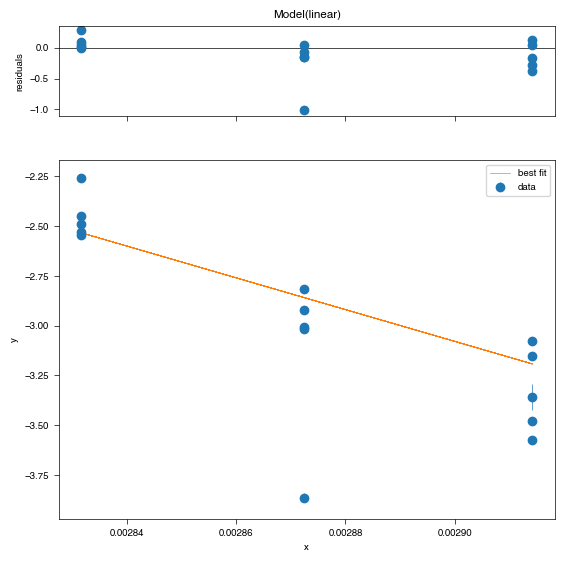

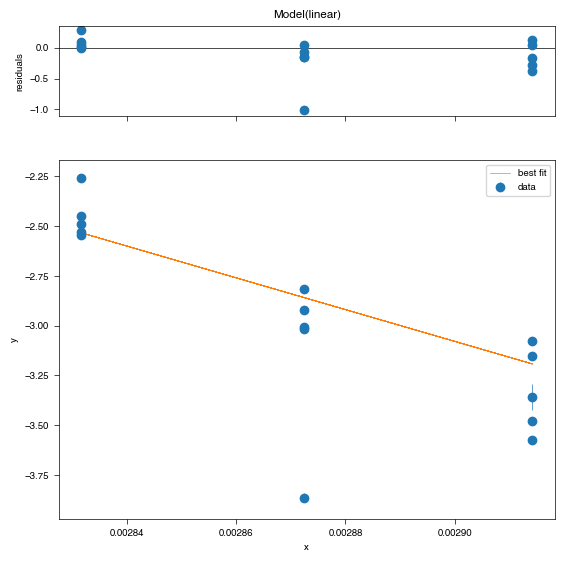

In [32]:
agg_HIV_C_arrhenius_fit.plot()